# Footprint Demo

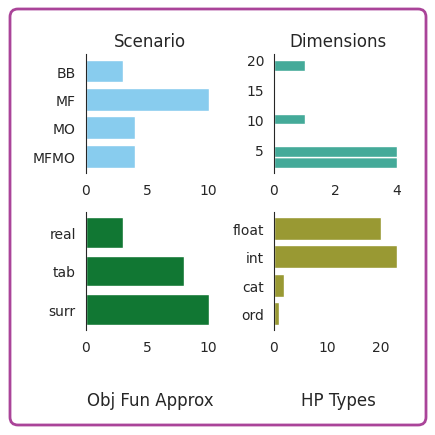

In [27]:
data = {
    "Scenario": {
        "BB": 3,
        "MF": 10,
        "MO": 4,
        "MFMO": 4,
    },
    "Dimensions":
        [2,4,5,5,5,3,3,3,10,20],
    "Obj Fun Approx": {
        "real": 3,
        "tab": 8,
        "surr": 10
    },
    "HP Types": {
        "float": 20,
        "int": 23,
        "cat": 2,
        "ord": 1,
    }
}

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from rich import inspect

sns.set_style("white")

fig = plt.figure(figsize=(4,4))
# inspect(fig.patch, all=True)
# fig.patch.set_linewidth(10)
# fig.patch.set_edgecolor('pink')  # substitute 'k' for black
# bbox = fig.patch.get_bbox()
# inspect(fig.patch, all=True)
# frame = mpatches.FancyBboxPatch(xy=(1,1), width=1, height=1, color="pink", fill=False)
# frame.set_in_layout(False)
# fig.add_artist(frame)

# # Add a rounded frame to the figure
# bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="none", linewidth=2)

# # Create the FancyBboxPatch
# frame = mpatches.FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure, **bbox_props)
# frame.set_in_layout(False)

# Add the frame to the figure's patches
# fig.patches.append(frame)

palette = ["#FDC5F5", "#F7AEF8", "#B388EB", "#8093F1", "#72DDF7"]
palette = ["#003844", "#006C67", "#F194B4", "#FFB100", "#FFEBC6"]
tol_muted_palette = [
    "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77",
    "#CC6677", "#882255", "#AA4499", "#DDDDDD"
]
palette = [
    tol_muted_palette[0],
    tol_muted_palette[1],
    tol_muted_palette[2],
    tol_muted_palette[3],
    tol_muted_palette[7],
]

axes = fig.subplots(nrows=2, ncols=2)
for i, (key, val) in enumerate(data.items()):
    ax = axes.flatten()[i]
    if key != "Dimensions":
        ax.barh(y=list(val.keys())[::-1], width=list(val.values())[::-1], color=palette[i])
    else:
        ax.hist(x=val, orientation="horizontal", color=palette[i])
    y = None
    if i >= 2:
        y = -0.7
    ax.set_title(key, y=y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    # ax.axis["left"].major_ticklabels.set_ha("left")
fig.set_tight_layout(True)

fig_width, fig_height = fig.get_size_inches()
fig_dpi = fig.get_dpi()

# Create the rounded frame
bbox_props = dict(boxstyle="round,pad=0.02", edgecolor=palette[-1], facecolor="none", linewidth=2)

# Create the FancyBboxPatch
frame = mpatches.FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure, **bbox_props)

# Add the frame to the figure's patches
fig.patches.append(frame)

# # Adjust layout to make more space between the axes and the title
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1, wspace=0.1)

# # Add a title in the center of the figure
# fig.text(0.5, 0.5, "Benchmark",
#          bbox=dict(boxstyle='square,pad=1', fc='none', ec='none'),
#           ha='center', va='center', fontsize=16, weight='bold', transform=fig.transFigure)



fig.savefig("benchmark_footprint_demo.png", bbox_inches="tight", dpi=300)


plt.show()

# Footprint Plots (Combined)

In [4]:
from omegaconf import OmegaConf
from pathlib import Path
import pandas as pd
from multiprocessing import Pool

config_folder = Path("../carps/configs/problem")
paths = list(config_folder.glob("**/*.yaml"))
paths = [p for p in paths if "DUMMY" not in str(p)]

def read_task(p) -> dict:
    cfg = OmegaConf.load(p)
    task = OmegaConf.to_container(cfg.task)
    task["benchmark_id"] = cfg.benchmark_id
    task["problem_id"] = cfg.problem_id
    return task

with Pool() as pool:
    tasks = pool.map(read_task, paths)
tasks = pd.DataFrame(tasks)

In [5]:
data = []
benchmark_id_list = tasks.benchmark_id.unique()
for benchmark_id in benchmark_id_list:
    tasks_id = tasks[tasks["benchmark_id"] == benchmark_id]
    BB = len(tasks_id[(tasks_id['n_objectives']==1) & (tasks_id['is_multifidelity']==False)])
    MF = len(tasks_id[(tasks_id['n_objectives']==1) & (tasks_id['is_multifidelity']==True)])
    MO = len(tasks_id[(tasks_id['n_objectives']>1) & (tasks_id['is_multifidelity']==False)])
    MOMF = len(tasks_id[(tasks_id['n_objectives']>1) & (tasks_id['is_multifidelity']==True)])
    dimensions = list(tasks_id['dimensions'])
    real = len(tasks_id[tasks_id['objective_function_approximation']=='real'])
    tab = len(tasks_id[tasks_id['objective_function_approximation']=='tabular'])
    surr = len(tasks_id[tasks_id['objective_function_approximation']=='surrogate'])
    float = tasks_id['search_space_n_floats'].sum()
    int = tasks_id['search_space_n_integers'].sum()
    cat = tasks_id['search_space_n_categoricals'].sum()
    ord = tasks_id['search_space_n_ordinals'].sum()

    data.append( {
        "Scenario": {
            "BB": BB,
            "MF": MF,
            "MO": MO,
            "MO-MF": MOMF,
        },
        "Dimensions": dimensions,
        "Objective Function": {
            "real": real,
            "tab": tab,
            "surr": surr
        },
        "HP Types": {
            "float": float,
            "int": int,
            "cat": cat,
            "ord": ord,
        }
    }
)

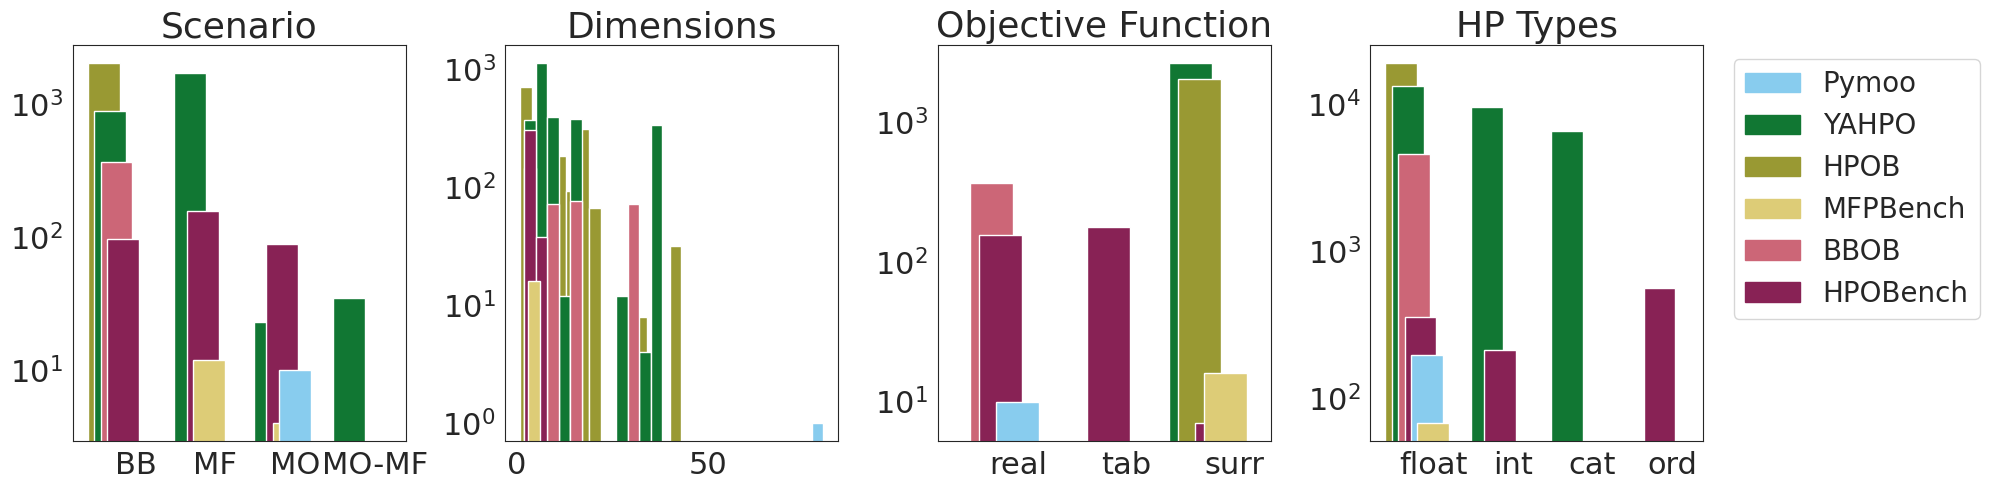

In [26]:
import matplotlib.pyplot as plt
import numpy as np

colors = dict(zip(benchmark_id_list, ['#88CCEE', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255']))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

scenarios = {}
obj_fun = {}
hp_types = {}
dimensions = {}

shift = 0.08
bar_width = 0.4

# Iterate over the dictionaries in the list
for i, data_entry in enumerate(data):
    # Iterate over the keys in the dictionary
    for j, (key, values) in enumerate(data_entry.items()):
        if j == 0:
            scenarios[benchmark_id_list[i]] = values
        elif j == 2:
            obj_fun[benchmark_id_list[i]] = values
        elif j == 3:
            hp_types[benchmark_id_list[i]] = values
        elif j==1:
            dimensions[benchmark_id_list[i]] = values

dimensions_sorted = dict(sorted(dimensions.items(), key=lambda item: max(item[1]), reverse=True))
for i, (key, values) in enumerate(dimensions_sorted.items()):
    axs[1].hist(values, bins=np.arange(min(values), max(values) + 1,3), color=colors[key])

scenarios_sorted = dict(sorted(scenarios.items(), key=lambda item: max(item[1].values()), reverse=True))
for i, (key, values) in enumerate(scenarios_sorted.items()):
    x = np.arange(len(values.keys())) + i * shift
    axs[0].bar(x, values.values(), color=colors[key], width=bar_width)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(values.keys())

obj_fun_sorted = dict(sorted(obj_fun.items(), key=lambda item: max(item[1].values()), reverse=True))
for i, (key, values) in enumerate(obj_fun_sorted.items()):
    x = np.arange(len(values.keys())) + i * shift
    axs[2].bar(x, values.values(), color=colors[key], width=bar_width)
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(values.keys())

hp_types_sorted = dict(sorted(hp_types.items(), key=lambda item: max(item[1].values()), reverse=True))
for i, (key, values) in enumerate(hp_types_sorted.items()):
    x = np.arange(len(values.keys())) + i * shift
    axs[3].bar(x, values.values(), color=colors[key], width=bar_width)#, alpha=0.5)
    axs[3].set_xticks(x)
    axs[3].set_xticklabels(values.keys())

# Add a legend to each subplot
for i, ax in enumerate(axs):
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_yscale('log')
    ax.set_title(list(data_entry.keys())[i], fontsize=26)

legend_handles = [mpatches.Patch(color=color, label=name) for name, color in colors.items()]

ax.legend(handles=legend_handles, fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
fig.savefig(f"benchmark_footprint.png", bbox_inches="tight", dpi=300)
plt.show()

# Footprint Plots

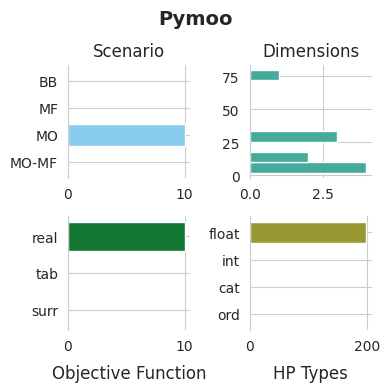

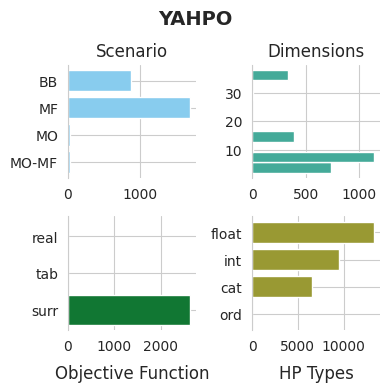

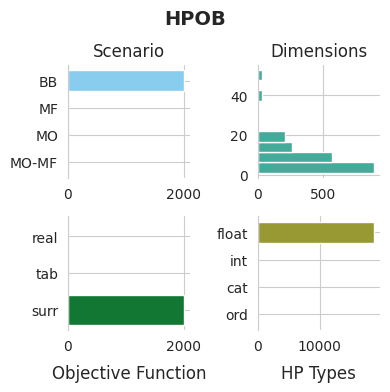

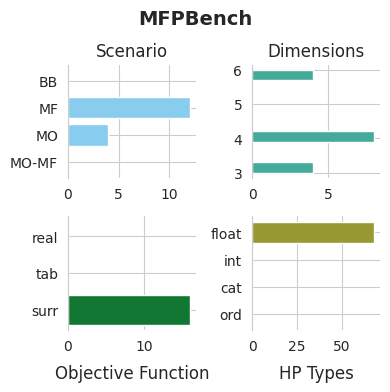

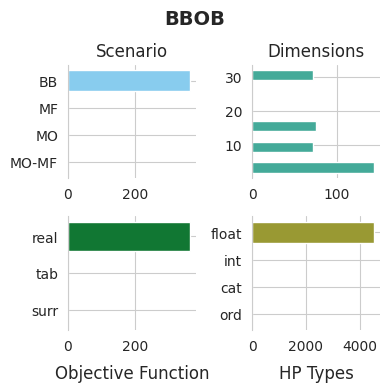

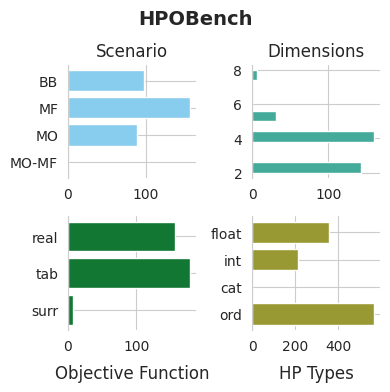

In [243]:
benchmark_id_list = tasks.benchmark_id.unique()
for benchmark_id in benchmark_id_list:
    tasks_id = tasks[tasks["benchmark_id"] == benchmark_id]
    BB = len(tasks_id[(tasks_id['n_objectives']==1) & (tasks_id['is_multifidelity']==False)])
    MF = len(tasks_id[(tasks_id['n_objectives']==1) & (tasks_id['is_multifidelity']==True)])
    MO = len(tasks_id[(tasks_id['n_objectives']>1) & (tasks_id['is_multifidelity']==False)])
    MOMF = len(tasks_id[(tasks_id['n_objectives']>1) & (tasks_id['is_multifidelity']==True)])
    dimensions = list(tasks_id['dimensions'])
    real = len(tasks_id[tasks_id['objective_function_approximation']=='real'])
    tab = len(tasks_id[tasks_id['objective_function_approximation']=='tabular'])
    surr = len(tasks_id[tasks_id['objective_function_approximation']=='surrogate'])
    float = tasks_id['search_space_n_floats'].sum()
    int = tasks_id['search_space_n_integers'].sum()
    cat = tasks_id['search_space_n_categoricals'].sum()
    ord = tasks_id['search_space_n_ordinals'].sum()

    data = {
        "Scenario": {
            "BB": BB,
            "MF": MF,
            "MO": MO,
            "MO-MF": MOMF,
        },
        "Dimensions": dimensions,
        "Objective Function": {
            "real": real,
            "tab": tab,
            "surr": surr
        },
        "HP Types": {
            "float": float,
            "int": int,
            "cat": cat,
            "ord": ord,
        }
    }

    fig = plt.figure(figsize=(4,4))

    axes = fig.subplots(nrows=2, ncols=2)
    for i, (key, val) in enumerate(data.items()):
        ax = axes.flatten()[i]
        if key != "Dimensions":
            ax.barh(y=list(val.keys())[::-1], width=list(val.values())[::-1], color=palette[i])
        else:
            ax.hist(x=val, orientation="horizontal", color=palette[i])
        y = None
        if i >= 2:
            y = -0.5
        ax.set_title(key, y=y)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(True)
        # ax.axis["left"].major_ticklabels.set_ha("left")
    fig.set_tight_layout(True)
    fig.suptitle(benchmark_id, y=0.96, fontsize=14, weight='bold')

    fig_width, fig_height = fig.get_size_inches()
    fig_dpi = fig.get_dpi()

    # Create the rounded frame
    bbox_props = dict(boxstyle="round,pad=0.02", edgecolor=palette[-1], facecolor="none", linewidth=2)

    # Create the FancyBboxPatch
    frame = mpatches.FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure, **bbox_props)

    # Add the frame to the figure's patches
    #fig.patches.append(frame)

    fig.savefig(f"benchmark_footprint_{benchmark_id}.png", bbox_inches="tight", dpi=300)

    plt.show()

# Test Plots

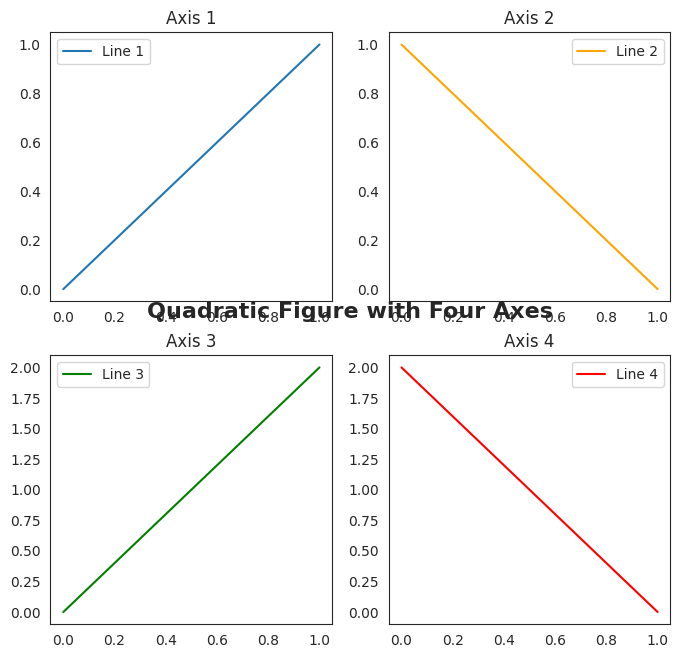

In [108]:
import matplotlib.pyplot as plt

# Create a quadratic figure
fig = plt.figure(figsize=(8, 8))

# Create four subplots
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Adjust layout to make space for the title
fig.subplots_adjust(top=0.85)

# Add a title in the center of the figure
fig.text(0.5, 0.5, "Quadratic Figure with Four Axes", ha='center', va='center', fontsize=16, weight='bold', transform=fig.transFigure)

# Example data for each subplot
ax1.plot([0, 1], [0, 1], label='Line 1')
ax2.plot([0, 1], [1, 0], label='Line 2', color='orange')
ax3.plot([0, 1], [0, 2], label='Line 3', color='green')
ax4.plot([0, 1], [2, 0], label='Line 4', color='red')

# Add titles and labels to each subplot
ax1.set_title('Axis 1')
ax2.set_title('Axis 2')
ax3.set_title('Axis 3')
ax4.set_title('Axis 4')

# Show legends
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# Display the plot
plt.show()

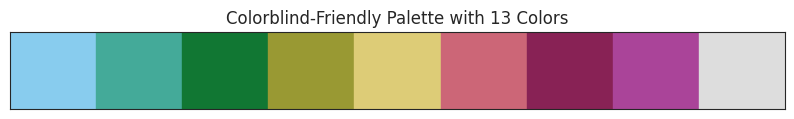

In [75]:
import matplotlib.pyplot as plt

# Define a colorblind-friendly color palette with 13 colors
colorblind_palette = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00",
    "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00"
]
colorblind_palette = [
    "#51A3A3",
    "#75485E",
    "#CB904D",
    "#DFCC74",
    "#C3E991"
]
colorblind_palette = ["#FDC5F5", "#F7AEF8", "#B388EB", "#8093F1", "#72DDF7"]
colorblind_palette = ["#003844", "#006C67", "#F194B4", "#FFB100", "#FFEBC6"]
colorblind_palette = [
    "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77",
    "#CC6677", "#882255", "#AA4499", "#DDDDDD"
]


# Create a sample plot to show the color palette
fig, ax = plt.subplots(figsize=(10, 1), dpi=100)

for i, color in enumerate(colorblind_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(colorblind_palette))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.title("Colorblind-Friendly Palette with 13 Colors")
plt.show()